In [10]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


# Titanic dataset

In [3]:
# kaggle c download titanic in input_dir
input_dir = '../input/'
df = pd.read_csv(os.path.join(input_dir, 'train.csv'))

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [7]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
#yeah sure that's harassment

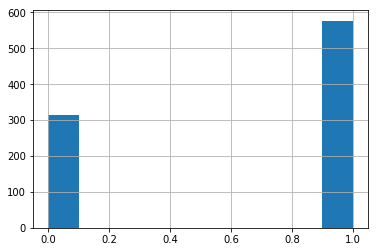

In [8]:
df['Sex'].hist()

In [27]:
def smoothed_likehood(df, global_means,  mean_cols=[], target_col='target', alpha=1,):
    '''
    :param df: data frame for mean_target
    :param global_means: Dict with keys - mean_cols. for each col - mean target for whole dataframe
    :param mean_cols: list with cols to build mean targets
    '''
    res_df = None
    for col in mean_cols:
        mean_target = df.groupby(col)[target_col].mean()
        # nrows — то, сколько раз встретилось конкретное значение категориальной переменной
        nrows = df[col].value_counts()
        res_df = (mean_target * nrows + global_means * alpha) / (nrows + alpha)
        #display(res_df)
        #df['smoothed_mean_target_' + str(col)] = df[col].apply(lambda x: res_df.loc[x])
    return res_df

In [28]:
kf = KFold()
folds = np.array(list(kf.split(df.drop('Survived', axis=1))))
global_means = dict()
global_means['Sex'] = df.groupby('Sex')['Survived'].mean()
sl = smoothed_likehood(df.iloc[folds[0][0]], global_means['Sex'], mean_cols=['Sex'], target_col='Survived')

In [29]:
sl

0    0.755914
1    0.202562
dtype: float64

In [68]:
df.groupby('Sex')['Survived'].mean()

Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64

In [65]:
def get_smoothed_mean_for_kfold_iter(df, train_ids, 
                                     cols = ['Sex'], 
                                     target_col='target', 
                                     subfolds_splits=3,
                                     alpha=1):
    '''
    df - whole dataframe
    train_ids - train fold
    cols - cols to get mean_targets
    target_col - column with target
    alpha - smoothing coef
    '''
    global_means = dict()
        
    train_df = df.iloc[train_ids]
    #test_df = df.iloc[test_ids]
    
    kf = KFold(n_splits=subfolds_splits)#, shuffle=True)
    subfolds = list(kf.split(train_df.drop(target_col, axis=1)))
    #using only first train fold to get features
    subtrain_means = dict()
    for col in cols:
        global_means[col] = df.groupby(col)[target_col].mean()
        subtrain_means[col] = smoothed_likehood(train_df.iloc[subfolds[0][0]], 
                                       global_means[col], 
                                       target_col=target_col, 
                                       mean_cols=cols,
                                       alpha=alpha)
    return subtrain_means

In [67]:
for train, _ in folds:
    res = get_smoothed_mean_for_kfold_iter(df, train_ids=train,
                                    cols=['Sex'], target_col='Survived')
    print(res)

{'Sex': 0    0.725318
1    0.207477
dtype: float64}
{'Sex': 0    0.718931
1    0.201446
dtype: float64}
{'Sex': 0    0.758065
1    0.205692
dtype: float64}
